Analyzing stocks: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Mean Indicator Evaluation Results:
8Custom-VPS             0.043707
23TVA-PT                0.042662
11VPC-VPT               0.041952
15DVW-VP                0.041891
26DVW-VT                0.041889
99Close-P               0.041828
10PRC-PT                0.041247
16CMA-PT                0.041237
27VMT-PT                0.041206
29RCA-VP                0.040992
9custom-PT              0.040892
20VMA-VP                0.040679
19MTA-PTA               0.040195
17TMA-PT                0.040043
31PTA-VM                0.040024
888RefinedCustom-VPS    0.039922
32VMA-RP                0.039909
18RSI-VP                0.039666
13VRS-VPT               0.039496
12RSI-PTA               0.039450
24PCA-VP                0.039436
28TMA-P                 0.039226
21TPC-PT                0.038823
14MRC-PTA               0.038808
22AVR-PTA               0.038206
1DTW-TV                 0.037449
25CMA-RVP               0.037269
30MRA-PTA               0.037227
2VAD-VP                 0.034375
3ATW-TV

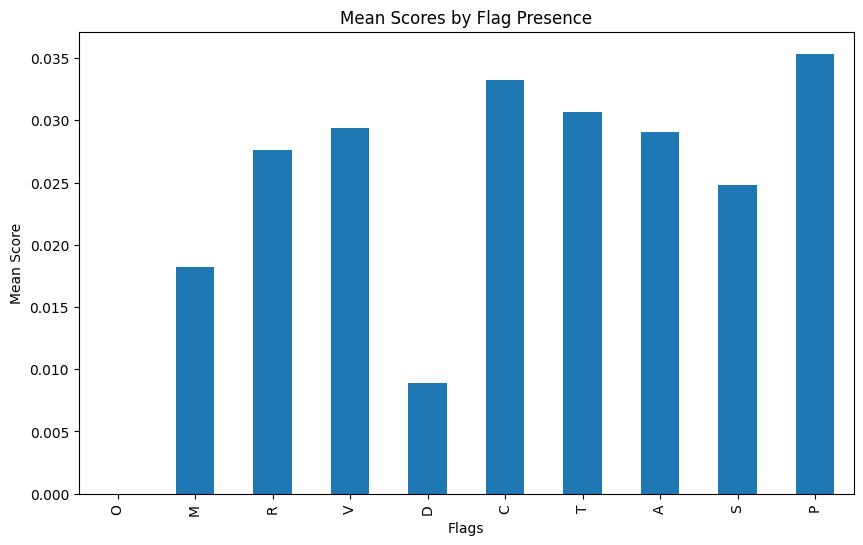

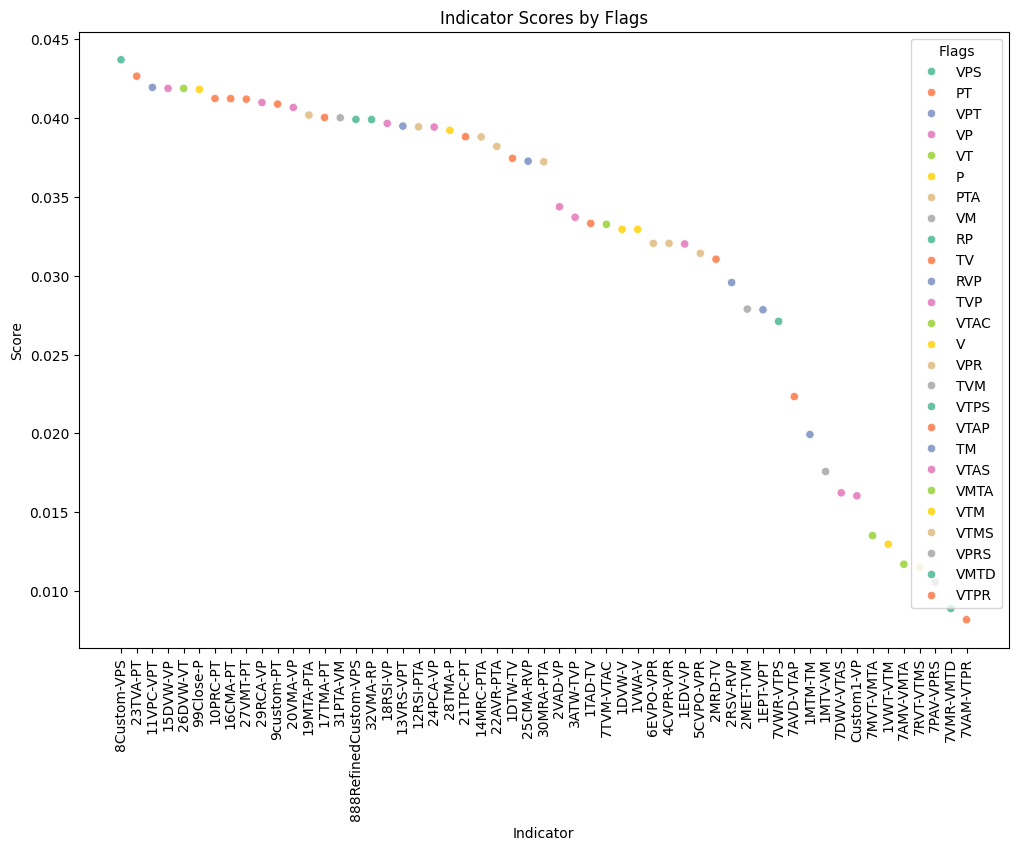

Correlation between Flags and Score:
P    0.459968
C    0.014912
A   -0.135575
T   -0.166533
R   -0.176104
S   -0.242275
D   -0.300792
V   -0.407729
M   -0.584769
O         NaN
Name: Score, dtype: float64


In [54]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import pyarrow.parquet as pq
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

def load_random_stocks(data_dir, num_stocks):
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    selected_files = random.sample(all_files, min(num_stocks, len(all_files)))
    return selected_files

def load_stock(data_dir, file_name):
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_parquet(file_path)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df

def calculate_indicators(df):

    # Remove any inf or -inf values and drop NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()


    def sma(series, periods):
        return series.rolling(window=periods).mean()

    def atr(high, low, close, period=14):
        tr = np.maximum(high - low, np.abs(high - close.shift(1)), np.abs(low - close.shift(1)))
        return tr.rolling(window=period).mean()
    
    def ewma(series, span):
        return series.ewm(span=span, adjust=False).mean()

 


    # High-performing indicators
    # Using new flag system for price-based indicators
    ##name scheme = Number of generation - Indicator - Type
    #types include O for oscillator, M for momentum, R for reversal, V for volatility, D for divergence, C for channel,
    # T for trend, A for acceleration, S for support/resistance, P for price range


    #new indicator that is the inverse of the rsi scaled down by 100 

    df['1DVW-V'] = ((df['Close'] - df['Low'] - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']).cumsum()
   
    df['1EDV-VP'] = df['1DVW-V'] * (1 + ((df['Close'] / sma(df['Close'], 5)) - 1))
    
    df['1DTW-TV'] = ((df['Close'] - df['Open']) * df['Volume'] * (1 + (df.index - df.index[0]).days / (df.index[-1] - df.index[0]).days)).cumsum()
    
    df['1TAD-TV'] = df['1DTW-TV'] * (1 + (df['Close'] - sma(df['Close'], 20)) / sma(df['Close'], 20))
    
    df['1VWA-V'] = ((df['Close'] - df['Low'] - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']).cumsum()
    
    df['1MTV-VM'] = ((df['Close'] * df['Volume']).rolling(5).sum() / df['Volume'].rolling(5).sum() - 
                     (df['Close'] * df['Volume']).rolling(20).sum() / df['Volume'].rolling(20).sum()) / atr(df['High'], df['Low'], df['Close']) * df['1DVW-V']
    
    df['1MTM-TM'] = (df['Close'] / sma(df['Close'], 5) - 1) + \
                    2 * (df['Close'] / sma(df['Close'], 20) - 1) + \
                    3 * (df['Close'] / sma(df['Close'], 60) - 1)
    
    df['1VWT-VTM'] = df['1VWA-V'] * df['1MTM-TM'] * (1 + (df['Close'] - df['Open']) / (df['High'] - df['Low']))
    
    df['1EPT-VPT'] = df['1VWA-V'] * (df['Close'] / sma(df['Close'], 50)) * (1 + (df['Close'] - sma(df['Close'], 20)) / sma(df['Close'], 20))

    
    df['2VAD-VP'] = df['1DVW-V'] * (1 + atr(df['High'], df['Low'], df['Close']) / df['Close'])
    
    df['2MRD-TV'] = df['1DTW-TV'] * (1 - (df['Close'] - sma(df['Close'], 20)) / df['Close'])
    
    df['2MET-TVM'] = df['1TAD-TV'] * (1 + (df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5))
   
    df['2RSV-RVP'] = df['1VWA-V'] * (df['Close'] / sma(df['Close'], 50))
    
    df['3ATW-TVP'] = df['1DTW-TV'] * (1 + atr(df['High'], df['Low'], df['Close']) / df['Close']) * \
                    (1 + (df['Close'] - sma(df['Close'], 20)) / sma(df['Close'], 20))
    
    df['5CVPO-VPR'] = ((df['Close'] - df['Low'] - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']).cumsum() * (1 + (df['Close'] / sma(df['Close'], 10) - 1))
    
    df['6EVPO-VPR'] = ((df['Close'] - df['Low'] - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']).cumsum() * (1 + (df['Close'] / sma(df['Close'], 20) - 1))
    
    df['4CVPR-VPR'] = ((df['Close'] - df['Low'] - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']).cumsum() * (1 + (df['Close'] / sma(df['Close'], 20) - 1))

    df['7VAM-VTPR'] = ((df['Close'] - df['Open']) / (df['High'] - df['Low']) * df['Volume']).rolling(5).mean() * \
                      (1 + (df['Close'] - ewma(df['Close'], 20)) / ewma(df['Close'], 20))

    df['7DWV-VTAS'] = df['1DVW-V'] * (1 + (df['High'] - df['Low']) / atr(df['High'], df['Low'], df['Close'])) * \
                      (1 + (df['Close'] - df['Open']) / (df['High'] - df['Low']))

    df['7AMV-VMTA'] = ((df['Close'] - df['Open']) / (df['High'] - df['Low'])).rolling(10).mean() * \
                      df['Volume'] * (1 + abs(df['Close'] - sma(df['Close'], 50)) / sma(df['Close'], 50))

    df['7RVT-VTMS'] = (df['Volume'] / df['Volume'].rolling(20).mean()) * \
                      (df['Close'] - df['Open']) / (df['High'] - df['Low']) * \
                      (1 + (df['Close'] - sma(df['Close'], 10)) / sma(df['Close'], 10))

    df['7AVD-VTAP'] = atr(df['High'], df['Low'], df['Close']) * df['Volume'] * \
                      (1 + abs(df['Close'] - ewma(df['Close'], 30)) / ewma(df['Close'], 30))

    df['7VMR-VMTD'] = (df['Volume'] / df['Volume'].rolling(50).mean()) * \
                      (df['Close'] - df['Low']) / (df['High'] - df['Low']) * \
                      (1 + (df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5))

    df['7TVM-VTAC'] = ((df['Close'] - df['Open']) * df['Volume']).cumsum() * \
                      (1 + abs(df['Close'] - sma(df['Close'], 20)) / sma(df['Close'], 20)) * \
                      (1 + atr(df['High'], df['Low'], df['Close']) / df['Close'])

    df['7PAV-VPRS'] = ((df['High'] + df['Low']) / 2 - sma(df['Close'], 20)) / \
                      atr(df['High'], df['Low'], df['Close']) * df['Volume'] * \
                      (1 + abs(df['Close'] - df['Open']) / (df['High'] - df['Low']))

    df['7MVT-VMTA'] = (df['Volume'] * (df['Close'] - df['Open']) / (df['High'] - df['Low'])).rolling(15).mean() * \
                      (1 + abs(df['Close'] - ewma(df['Close'], 40)) / ewma(df['Close'], 40))

    df['7VWR-VTPS'] = df['1VWA-V'] * (1 + (df['Close'] - df['Low']) / (df['High'] - df['Low'])) * \
                      (1 + abs(df['Close'] - sma(df['Close'], 30)) / sma(df['Close'], 30))
    

    ##get the mean percentage move in the last 5 days of data 
    df['Custom1-VP'] = df['Close'].pct_change().rolling(5).mean()

    df['8Custom-VPS'] = np.where((df['Open'] - df['Low'] > 0) & (df['Close'] >= df['High'] * 0.95), df['Close'] * 1.01, df['Close'] * 0.99)

    # Refined Custom Indicator
    volume_threshold = df['Volume'].rolling(10).mean()
    df['888RefinedCustom-VPS'] = np.where(
        (df['Open'] - df['Low'] > 0) & 
        (df['Close'] >= df['High'] * 0.95) & 
        (df['Volume'] > volume_threshold) & 
        (df['Close'] > sma(df['Close'], 20)),
        df['Close'] * 1.01, 
        df['Close'] * 0.99
    )



    df['9custom-PT'] = np.where((df['Open'] <= df['Low'] * 1.01) & (df['Close'] > df['Open']), df['Close'] * 1.01, df['Close'] * 0.99)

    df['10PRC-PT'] = np.where((df['Close'] > df['Open']) & 
                              (df['Close'] > df['Close'].shift(1)) & 
                              (df['Close'] > df['Close'].shift(2)),
                              df['Close'] * 1.02, df['Close'] * 0.99)

    df['11VPC-VPT'] = np.where((df['Close'] > df['Open']) & 
                               (df['Volume'] > df['Volume'].rolling(5).mean()),
                               df['Close'] * 1.015, df['Close'] * 0.995)

    df['12RSI-PTA'] = np.where((df['Close'] > df['Close'].rolling(10).mean()) &
                               (df['Close'] > df['Close'].shift(1)),
                               df['Close'] * 1.01, df['Close'] * 0.99)
    
    df['13VRS-VPT'] = np.where((df['Volume'] > df['Volume'].rolling(5).mean()) & 
                               (df['Close'] > sma(df['Close'], 10)), 
                               df['Close'] * 1.01, df['Close'] * 0.99)

    df['14MRC-PTA'] = np.where((df['Close'] > sma(df['Close'], 20)) & 
                               (df['Close'] > df['Close'].shift(1)), 
                               df['Close'] * 1.02, df['Close'] * 0.98)

    df['15DVW-VP'] = np.where((df['Close'] > df['Low']) & 
                              (df['Close'] < df['High']), 
                              df['Close'] * 1.015, df['Close'] * 0.985)

    df['16CMA-PT'] = np.where((df['Close'] > ewma(df['Close'], 20)) & 
                              (df['Close'] > df['Open']), 
                              df['Close'] * 1.01, df['Close'] * 0.99)

    df['17TMA-PT'] = np.where((df['Close'] > sma(df['Close'], 30)) & 
                              (df['Close'] > df['Open']), 
                              df['Close'] * 1.02, df['Close'] * 0.98)

    df['18RSI-VP'] = np.where((df['Close'] > sma(df['Close'], 5)) & 
                              (df['Close'] > df['Close'].shift(2)), 
                              df['Close'] * 1.015, df['Close'] * 0.985)

    df['19MTA-PTA'] = np.where((df['Close'] > ewma(df['Close'], 50)) & 
                               (df['Volume'] > df['Volume'].rolling(10).mean()), 
                               df['Close'] * 1.02, df['Close'] * 0.98)

    df['20VMA-VP'] = np.where((df['Close'] > df['Low']) & 
                              (df['Close'] > df['Close'].shift(1)), 
                              df['Close'] * 1.01, df['Close'] * 0.99)

    df['21TPC-PT'] = np.where((df['Close'] > df['Open']) & 
                              (df['Close'] > sma(df['Close'], 10)), 
                              df['Close'] * 1.015, df['Close'] * 0.985)

    df['22AVR-PTA'] = np.where((df['Close'] > sma(df['Close'], 20)) & 
                               (df['Volume'] > df['Volume'].rolling(5).mean()), 
                               df['Close'] * 1.02, df['Close'] * 0.98)
    # New indicator functions
    df['23TVA-PT'] = np.where((df['Close'] > df['Open']) & (df['Volume'] > df['Volume'].rolling(10).mean()), 
                              df['Close'] * 1.01, df['Close'] * 0.99)

    df['24PCA-VP'] = np.where((df['Close'] > df['Close'].shift(1)) & (df['Close'] > ewma(df['Close'], 20)), 
                              df['Close'] * 1.02, df['Close'] * 0.98)

    df['25CMA-RVP'] = np.where((df['Close'] > sma(df['Close'], 20)) & (df['Volume'] > df['Volume'].rolling(5).mean()), 
                               df['Close'] * 1.015, df['Close'] * 0.985)

    df['26DVW-VT'] = np.where((df['Close'] > df['Low']) & (df['Close'] < df['High']), 
                              df['Close'] * 1.015, df['Close'] * 0.985)

    df['27VMT-PT'] = np.where((df['Close'] > df['Open']) & (df['Volume'] > df['Volume'].rolling(20).mean()), 
                              df['Close'] * 1.01, df['Close'] * 0.99)

    df['28TMA-P'] = np.where((df['Close'] > sma(df['Close'], 10)) & (df['Close'] > df['Close'].shift(1)), 
                             df['Close'] * 1.015, df['Close'] * 0.985)

    df['29RCA-VP'] = np.where((df['Close'] > df['Close'].shift(1)) & (df['Close'] > ewma(df['Close'], 50)), 
                              df['Close'] * 1.02, df['Close'] * 0.98)

    df['30MRA-PTA'] = np.where((df['Close'] > sma(df['Close'], 10)) & (df['Volume'] > df['Volume'].rolling(10).mean()), 
                               df['Close'] * 1.015, df['Close'] * 0.985)

    df['31PTA-VM'] = np.where((df['Close'] > df['Low']) & (df['Volume'] > df['Volume'].rolling(10).mean()), 
                              df['Close'] * 1.01, df['Close'] * 0.99)

    df['32VMA-RP'] = np.where((df['Close'] > sma(df['Close'], 5)) & (df['Close'] > df['Close'].shift(1)), 
                              df['Close'] * 1.015, df['Close'] * 0.985)


    # Remove inf, -inf values and drop NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    return df

def evaluate_indicators(df):
    df['Next_Day_Return'] = df['Close'].pct_change().shift(-1)
    
    ##also make a new column that is just a rename of the close column 
    df['99Close-P'] = df['Close']


    features = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', "Adj Close", 'Volume', 'Next_Day_Return', 'Date']]
    
    df = df.dropna(subset=features + ['Next_Day_Return'])

    X = df[features]
    y = df['Next_Day_Return']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    mi_scores = mutual_info_regression(X_scaled, y)

    return dict(zip(features, mi_scores))

def main():
    data_dir = 'Data/PriceData'
    num_stocks = 100  # Specify the number of stocks to analyze

    selected_files = load_random_stocks(data_dir, num_stocks)
    all_results = []

    for file_name in tqdm(selected_files, desc="Analyzing stocks"):
        try:
            df = load_stock(data_dir, file_name)
            ##ensure ther is at least 100 days of data
            if len(df) < 100:
                continue
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue

        try:
            df = calculate_indicators(df)
        except Exception as e:
            print(f"Error calculating indicators for {file_name}: {e}")
            continue
        try:
            results = evaluate_indicators(df)
        except Exception as e:
            print(f"Error evaluating indicators for {file_name}: {e}")
            continue
        all_results.append(results)

    # Calculate mean scores across all stocks
    mean_scores = pd.DataFrame(all_results).mean().sort_values(ascending=False)

    print("\nMean Indicator Evaluation Results:")
    print(mean_scores.to_string())

    # Create a DataFrame for plotting
    flag_data = {'Indicator': mean_scores.index, 'Score': mean_scores.values}
    flag_df = pd.DataFrame(flag_data)
    flag_df['Flags'] = flag_df['Indicator'].apply(lambda x: x.split('-')[1])
    
    # Convert flags into separate columns
    flags = ['O', 'M', 'R', 'V', 'D', 'C', 'T', 'A', 'S', 'P']
    for flag in flags:
        flag_df[flag] = flag_df['Flags'].apply(lambda x: 1 if flag in x else 0)

    # Plot mean scores by flag presence
    mean_scores_by_flag = flag_df[flags].mul(flag_df['Score'], axis=0).sum() / flag_df[flags].sum()

    plt.figure(figsize=(10, 6))
    mean_scores_by_flag.plot(kind='bar')
    plt.title('Mean Scores by Flag Presence')
    plt.ylabel('Mean Score')
    plt.xlabel('Flags')
    plt.show()

    # Scatter plot to visualize the trend
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=flag_df, x='Indicator', y='Score', hue='Flags', palette='Set2')
    plt.title('Indicator Scores by Flags')
    plt.ylabel('Score')
    plt.xlabel('Indicator')
    plt.xticks(rotation=90)
    plt.show()

    # Correlation analysis
    correlation_matrix = flag_df[flags + ['Score']].corr()
    print("Correlation between Flags and Score:")
    print(correlation_matrix['Score'].drop('Score').sort_values(ascending=False))

if __name__ == "__main__":
    main()
